In [105]:
import torch
torch.set_printoptions(linewidth=200, threshold=100000)

In [106]:
import sys
sys.path.append('/home/max/myrepos/vlstm_cuda/')
from plot_utils import plot_numerical_diffs_single

In [107]:
from ln import MultiHeadLayerNorm

from mlstm_parallel import mlstm_torch_autograd, mlstm_torch_ownbw, mlstm_triton

In [108]:
# params
S = 32 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 64 # dim per head
DTYPE = torch.float32
PT_AG_DTYPE = torch.float16
PT_OBW_DTYPE = torch.float16
TR_DTYPE = torch.float16
DEVICE = torch.device("cuda:0")
EPS = 0.0

In [109]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1)
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
igs = torch.rand((B, NH, S), device=DEVICE, dtype=DTYPE)
igs2 = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S)
fgs = torch.rand((B, NH, S), device=DEVICE, dtype=DTYPE)
qs.shape, fgs.shape

(torch.Size([1, 1, 32, 64]), torch.Size([1, 1, 32]))

In [110]:
offset = 3.* torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [111]:
mh_layernorm = MultiHeadLayerNorm(NH*DH, eps=1e-6).to(device=DEVICE, dtype=DTYPE)
mh_layernorm.weight, mh_layernorm.bias

(Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', requires_grad=True),
 None)

## pytorch

In [112]:
fgs_pt = fgs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
igs_pt = igs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
qs_pt = qs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
ks_pt = ks.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
vs_pt = vs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)

In [113]:
qs_pt.grad

In [114]:
hs_pt, _, _ = mlstm_torch_autograd(qs_pt, ks_pt, vs_pt, igs_pt, fgs_pt)
hs_pt_scaled = mh_layernorm(hs_pt)

In [115]:
((hs_pt_scaled+offset)**2).sum().backward()

## own backward torch

In [116]:
fgs_obw = fgs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
igs_obw = igs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
qs_obw = qs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
ks_obw = ks.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
vs_obw = vs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)

In [117]:
hs_obw = mlstm_torch_ownbw(qs_obw, ks_obw, vs_obw, igs_obw, fgs_obw)
hs_obw_scaled = mh_layernorm(hs_obw)

In [118]:
((hs_obw_scaled+offset)**2).sum().backward()

In [119]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== PT Autograd -> PT Own backward ======")
print(f"dQ match: {torch.allclose(qs_pt.grad.float(), qs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(qs_pt.grad - qs_obw.grad))}")
print(f"dK match: {torch.allclose(ks_pt.grad.float(), ks_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(ks_pt.grad - ks_obw.grad))}")
print(f"dV match: {torch.allclose(vs_pt.grad.float(), vs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(vs_pt.grad - vs_obw.grad))}")
print(f"dI match: {torch.allclose(igs_pt.grad.float(), igs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(igs_pt.grad - igs_obw.grad))}")
print(f"dF match: {torch.allclose(fgs_pt.grad.float(), fgs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(fgs_pt.grad - fgs_obw.grad))}")

====== PT Autograd -> PT Own backward ======
dQ match: False, max diff: 0.01953125
dK match: False, max diff: 0.03125
dV match: False, max diff: 0.015625
dI match: False, max diff: 0.0625
dF match: False, max diff: 0.15771484375


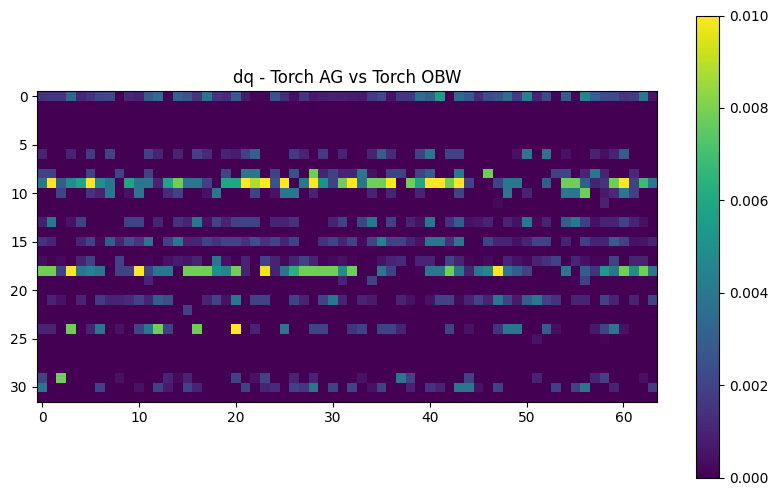

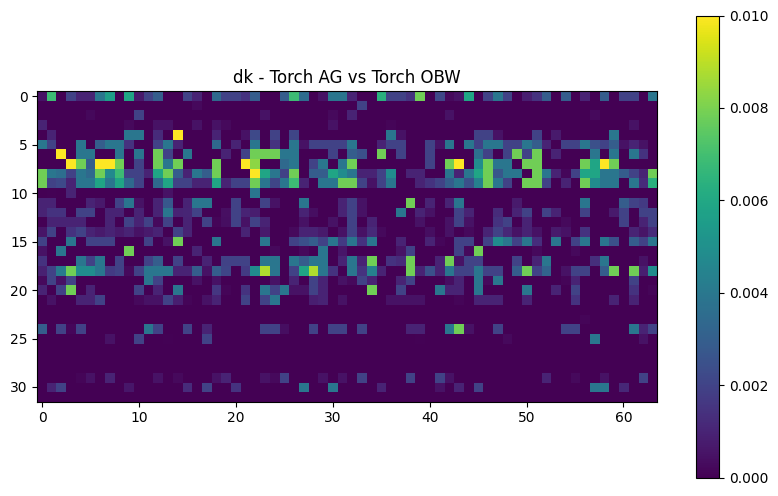

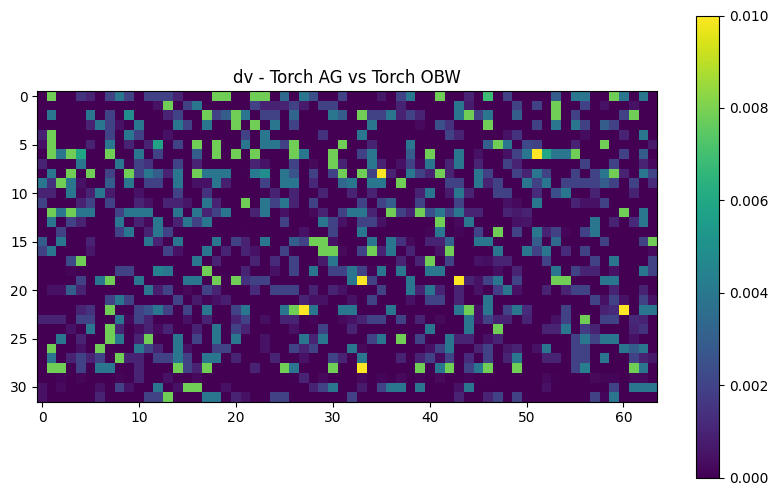

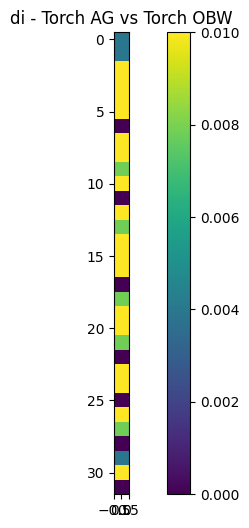

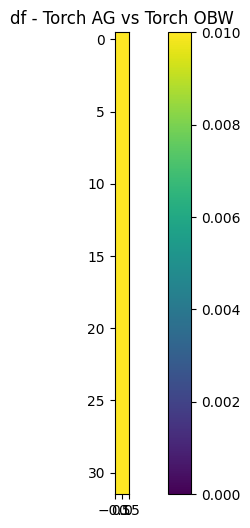

In [120]:
vmax = 0.01
fig = plot_numerical_diffs_single(qs_pt.grad, qs_obw.grad, "dq - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(ks_pt.grad, ks_obw.grad, "dk - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(vs_pt.grad, vs_obw.grad, "dv - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(igs_pt.grad, igs_obw.grad, "di - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(fgs_pt.grad, fgs_obw.grad, "df - Torch AG vs Torch OBW", vmax=vmax)

## triton

In [121]:
import triton
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [122]:
fgs_tr = fgs.clone().to(TR_DTYPE).detach().requires_grad_(True)
igs_tr = igs.clone().to(TR_DTYPE).detach().requires_grad_(True)
qs_tr = qs.clone().to(TR_DTYPE).detach().requires_grad_(True)
ks_tr = ks.clone().to(TR_DTYPE).detach().requires_grad_(True)
vs_tr = vs.clone().to(TR_DTYPE).detach().requires_grad_(True)

In [123]:
hs_tr = mlstm_triton(qs_tr, ks_tr, vs_tr, igs_tr, fgs_tr)
hs_tr_scaled = mh_layernorm(hs_tr)

In [132]:
hs_tr_scaled.max()

tensor(3.3789, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>)

In [125]:
print(f"hs match: {torch.allclose(hs_pt_scaled.float(), hs_tr_scaled.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_scaled - hs_tr_scaled))}")


hs match: False, max diff: 0.001953125


In [126]:
((hs_tr_scaled+offset)**2).sum().backward()

In [131]:
hs_tr_scaled.max()

tensor(3.3789, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>)

In [128]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Triton -> PT Autograd ======")
print(f"hs match: {torch.allclose(hs_pt_scaled.float(), hs_tr_scaled.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_scaled - hs_tr_scaled))}")
print(f"dQ match: {torch.allclose(qs_pt.grad.float(), qs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(qs_pt.grad - qs_tr.grad))}")
print(f"dK match: {torch.allclose(ks_pt.grad.float(), ks_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(ks_pt.grad - ks_tr.grad))}")
print(f"dV match: {torch.allclose(vs_pt.grad.float(), vs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(vs_pt.grad - vs_tr.grad))}")
print(f"dI match: {torch.allclose(igs_pt.grad.float(), igs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(igs_pt.grad - igs_tr.grad))}")
print(f"dF match: {torch.allclose(fgs_pt.grad.float(), fgs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(fgs_pt.grad - fgs_tr.grad))}")

print(f" ====== Triton -> PT Own backward ======")
print(f"hs match: {torch.allclose(hs_obw_scaled.float(), hs_tr_scaled.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_obw_scaled - hs_tr_scaled))}")
print(f"dQ match: {torch.allclose(qs_obw.grad.float(), qs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(qs_obw.grad - qs_tr.grad))}")
print(f"dK match: {torch.allclose(ks_obw.grad.float(), ks_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(ks_obw.grad - ks_tr.grad))}")
print(f"dV match: {torch.allclose(vs_obw.grad.float(), vs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(vs_obw.grad - vs_tr.grad))}")
print(f"dI match: {torch.allclose(igs_obw.grad.float(), igs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(igs_obw.grad - igs_tr.grad))}")
print(f"dF match: {torch.allclose(fgs_obw.grad.float(), fgs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(fgs_obw.grad - fgs_tr.grad))}")

====== Triton -> PT Autograd ======
hs match: False, max diff: 0.001953125
dQ match: False, max diff: 0.03125
dK match: False, max diff: 0.03125
dV match: False, max diff: 0.0234375
dI match: False, max diff: 0.0625
dF match: False, max diff: 0.0703125
 ====== Triton -> PT Own backward ======
hs match: False, max diff: 0.001953125
dQ match: False, max diff: 0.03125
dK match: False, max diff: 0.03125
dV match: False, max diff: 0.0234375
dI match: False, max diff: 0.0625
dF match: False, max diff: 0.100341796875


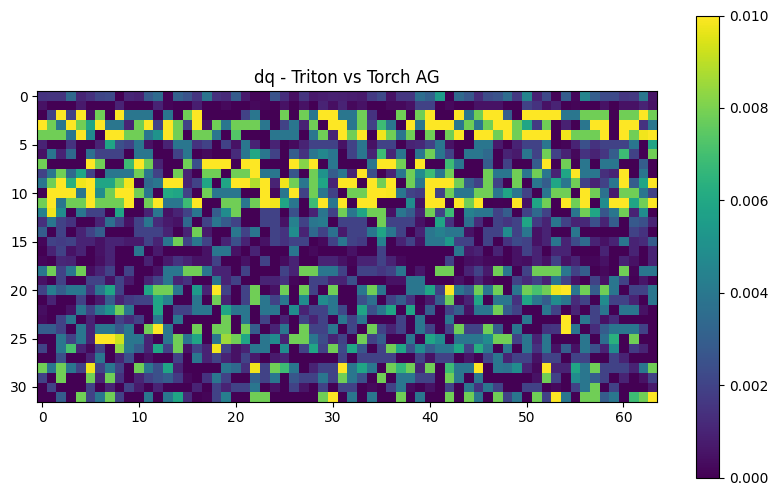

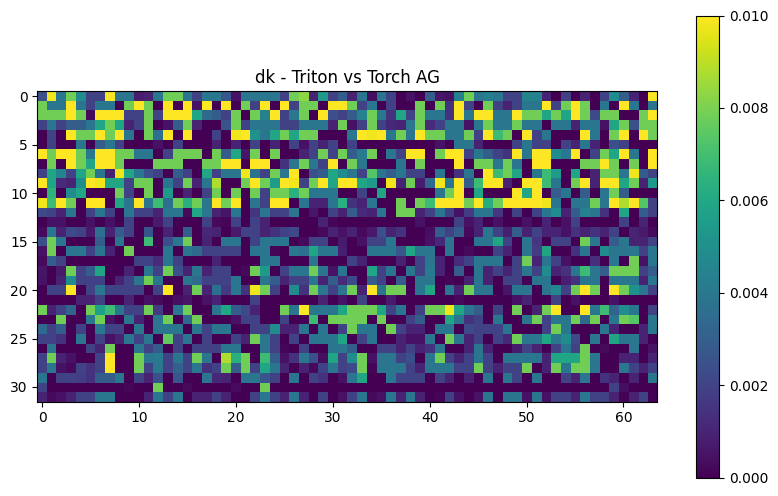

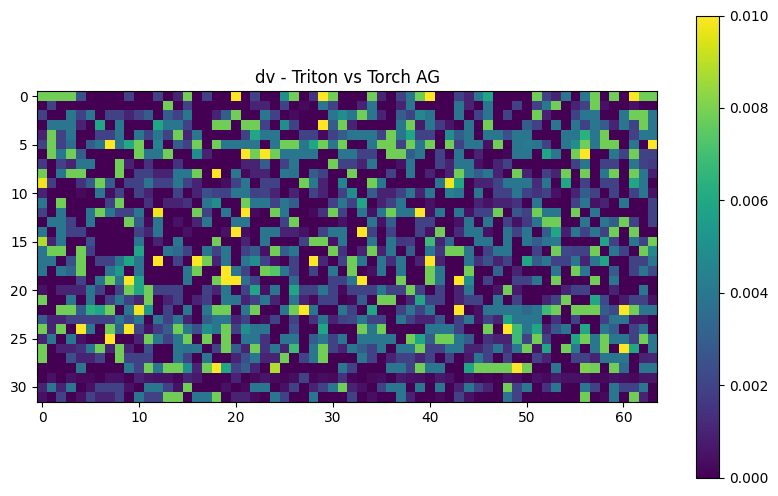

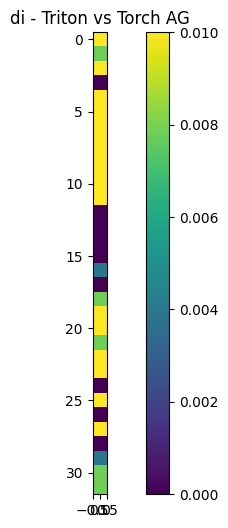

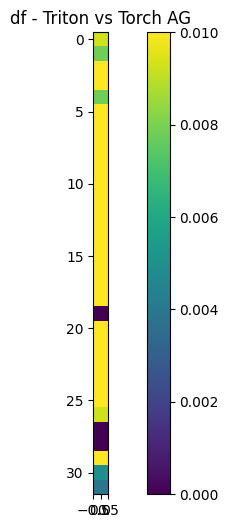

In [129]:
# Triton -> PT Autograd
vmax = 0.01
fig = plot_numerical_diffs_single(qs_tr.grad, qs_pt.grad, "dq - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(ks_tr.grad, ks_pt.grad, "dk - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(vs_tr.grad, vs_pt.grad, "dv - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(igs_tr.grad, igs_pt.grad, "di - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(fgs_tr.grad, fgs_pt.grad, "df - Triton vs Torch AG", vmax=vmax)

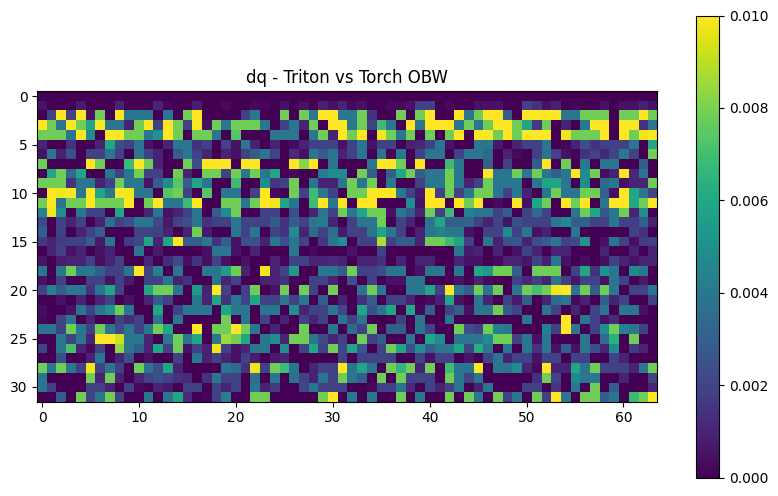

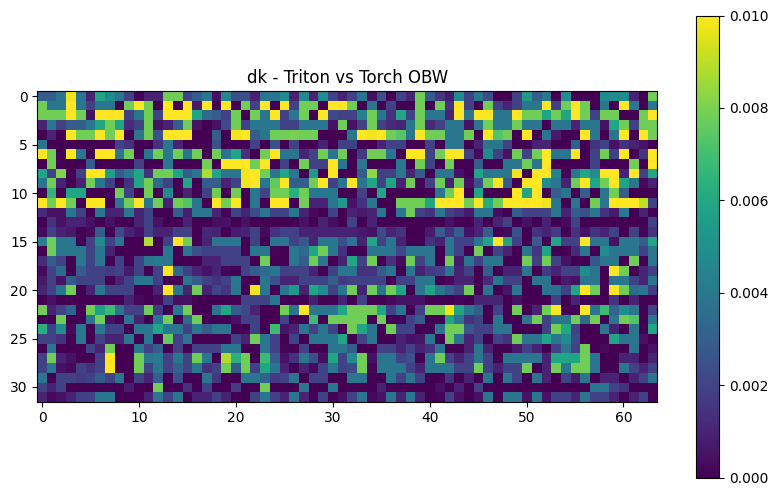

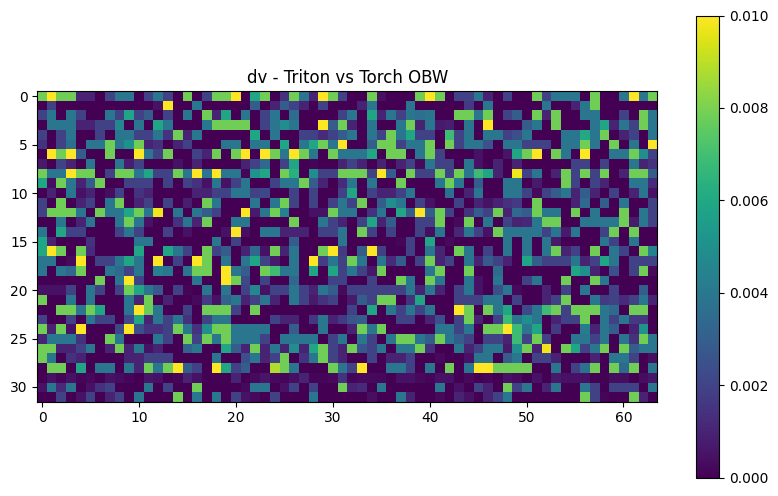

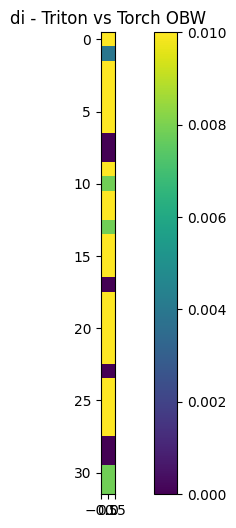

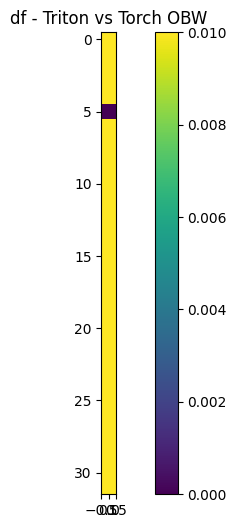

In [130]:
# Triton -> PT OBW
vmax = 0.01
fig = plot_numerical_diffs_single(qs_tr.grad, qs_obw.grad, "dq - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(ks_tr.grad, ks_obw.grad, "dk - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(vs_tr.grad, vs_obw.grad, "dv - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(igs_tr.grad, igs_obw.grad, "di - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(fgs_tr.grad, fgs_obw.grad, "df - Triton vs Torch OBW", vmax=vmax)